# English Premier League (EPL) Pythagorean Predictor

## Pythagorean Expectation

Expected Win% $\propto\frac{x^2}{x^2 + y^2}$, where

- x = parameter scored
- y = parameter conceded

In [1]:
# Importing Packages

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Custom
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_formats = ['svg'] # makes everything svg by default
%matplotlib inline

In [4]:
# Read Data

dataset = pd.read_excel('ds/EPL2017-18.xlsx')

display( dataset.head() )

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,20170811,Arsenal,Leicester,4,3,H
1,20170812,Brighton,Man City,0,2,A
2,20170812,Chelsea,Burnley,2,3,A
3,20170812,Crystal Palace,Huddersfield,0,3,A
4,20170812,Everton,Stoke,1,0,H


In [5]:
# Cleanup
dataset['count'] = 1

dataset['hwinvalue'] = np.where( dataset['FTR']=='H',1, np.where(dataset['FTR']=='D',.5,0) )
dataset['awinvalue'] = np.where( dataset['FTR']=='A',1, np.where(dataset['FTR']=='D',.5,0) )

home1 = dataset[dataset.Date < 20180000].groupby(['HomeTeam'])['count','hwinvalue', 'FTHG','FTAG']\
    .sum().reset_index()
home1 = home1.rename(columns={'HomeTeam':'Team','count':'MPh','FTHG':'GFh', 'FTAG':'GAh'})

away1 = dataset[dataset.Date < 20180000].groupby(['AwayTeam'])['count','awinvalue', 'FTHG','FTAG']\
    .sum().reset_index()
away1 = away1.rename(columns={'AwayTeam':'Team','count':'MPa','FTHG':'GAa','FTAG':'GFa'})
# because my goals in away ground will be home goals against for the other team


home2 = dataset[dataset.Date > 20180000].groupby(['HomeTeam'])['count','hwinvalue', 'FTHG','FTAG']\
    .sum().reset_index()
home2 = home2.rename(columns={'HomeTeam':'Team','count':'MPh','FTHG':'GFh', 'FTAG':'GAh'})

away2 = dataset[dataset.Date > 20180000].groupby(['AwayTeam'])['count','awinvalue', 'FTHG','FTAG']\
    .sum().reset_index()
away2 = away2.rename(columns={'AwayTeam':'Team','count':'MPa','FTHG':'GAa','FTAG':'GFa'})
# because my goals in away ground will be home goals against for the other team

half1 = pd.merge(home1, away1, on="Team")
half2 = pd.merge(home2, away2, on="Team")

In [6]:
# Evaluations
halves = [half1, half2]

for half in halves:
    half["MP"] = half["MPh"] + half["MPa"]
    half["wValue"] = half["hwinvalue"] + half["awinvalue"]
    half["GF"] = half["GFh"] + half["GFa"]
    half["GA"] = half["GAh"] + half["GAa"]


half1["pyth1"] = (half1["GF"]**2) / (half1["GF"]**2 + half1["GA"]**2)
half1["wpc1"] = half1["wValue"]/half1["MP"]


half2["pyth2"] = (half2["GF"]**2) / (half2["GF"]**2 + half2["GA"]**2)
half2["wpc2"] = half2["wValue"]/half2["MP"]

In [7]:
# Cleaned up Dataset
dropCols = ["MPh", "hwinvalue", "GFh", "GAh", "MPa", "awinvalue", "GFa", "GAa"]

for half in halves:
    display( 
        half.drop(columns = dropCols).head()
    )

,Team,MP,wValue,GF,GA,pyth1,wpc1
0,Arsenal,21,13.5,38,26,0.681132,0.642857
1,Bournemouth,21,7.5,20,32,0.280899,0.357143
2,Brighton,21,8.5,15,25,0.264706,0.404762
3,Burnley,21,12.5,18,17,0.528548,0.595238
4,Chelsea,21,15.5,39,14,0.885847,0.738095


,Team,MP,wValue,GF,GA,pyth2,wpc2
0,Arsenal,17,8.5,36,25,0.674649,0.500000
1,Bournemouth,17,9.0,25,29,0.426330,0.529412
2,Brighton,17,7.0,19,29,0.300333,0.411765
3,Burnley,17,7.5,18,22,0.400990,0.441176
4,Chelsea,17,9.0,23,24,0.478733,0.529412


In [15]:
# using half 1 pyth as predictor for half 2 wpc
predictor = pd.merge(half1, half2, on = "Team")
display(predictor.head())

,Team,MPh_x,hwinvalue_x,GFh_x,GAh_x,MPa_x,awinvalue_x,GAa_x,GFa_x,MP_x,...,awinvalue_y,GAa_y,GFa_y,MP_y,wValue_y,GF_y,GA_y,pyth2,wpc2,gap
0,Arsenal,10,8.5,25,10,11,5.0,16,13,21,...,1.0,15,7,17,8.5,36,25,0.674649,0.500000,6.5
1,Bournemouth,11,4.5,14,17,10,3.0,15,6,21,...,4.0,16,13,17,9.0,25,29,0.426330,0.529412,1.0
2,Brighton,10,5.5,10,12,11,3.0,13,5,21,...,1.5,16,5,17,7.0,19,29,0.300333,0.411765,4.0
3,Burnley,10,6.0,7,6,11,6.5,11,11,21,...,4.0,11,9,17,7.5,18,22,0.400990,0.441176,0.5
4,Chelsea,11,8.5,21,7,10,7.0,7,18,21,...,4.5,15,14,17,9.0,23,24,0.478733,0.529412,0.0


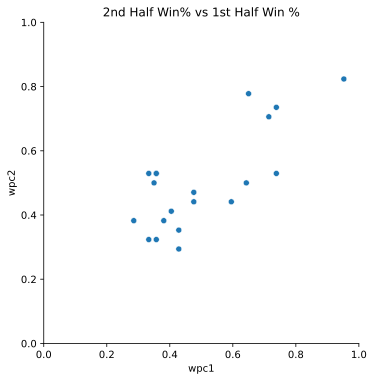

In [18]:
title = "2nd Half Win% vs 1st Half Win %"

sns.relplot(x="wpc1", y="wpc2", data = predictor)
plt.title(title)
plt.xlim(0, 1), plt.ylim(0, 1)
plt.savefig(title + ".svg", dpi=300, bbox_inches = 'tight')
plt.show()

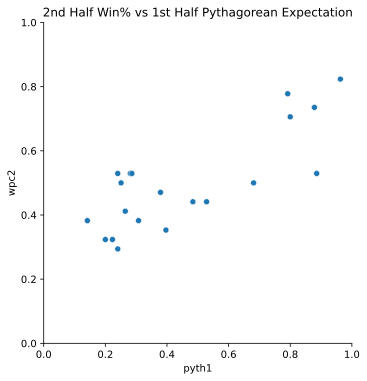

In [20]:
title = "2nd Half Win% vs 1st Half Pythagorean Expectation"

# Plotting
sns.relplot(x="pyth1", y="wpc2", data = predictor)
plt.title(title)
plt.xlim(0, 1), plt.ylim(0, 1)
plt.savefig(title + ".svg", dpi=300, bbox_inches = 'tight')
plt.show()

In [17]:
regression = smf.ols(formula = 'wpc2 ~ wpc1', data=predictor).fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wpc2   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     24.10
Date:                Sat, 09 Apr 2022   Prob (F-statistic):           0.000113
Time:                        08:19:08   Log-Likelihood:                 18.002
No. Observations:                  20   AIC:                            -32.00
Df Residuals:                      18   BIC:                            -30.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1800      0.069      2.607      0.018       0.035       0.325
wpc1           0.6384      0.130      4.909      0.000       0.365       0.912
==============================================================================
Omnibus:                        2.990   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.224   Jarque-Bera (JB):                1.319
Skew:                           0.196   Prob(JB):                        0.517
Kurtosis:                       1.805   Cond. No.                         7.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
# Regression

regression = smf.ols(formula = 'wpc2 ~ pyth1', data=predictor).fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wpc2   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     31.06
Date:                Sat, 09 Apr 2022   Prob (F-statistic):           2.73e-05
Time:                        08:16:43   Log-Likelihood:                 19.534
No. Observations:                  20   AIC:                            -35.07
Df Residuals:                      18   BIC:                            -33.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2897      0.043      6.690      0.000       0.199       0.381
pyth1          0.4543      0.082      5.573      0.000       0.283       0.626
==============================================================================
Omnibus:                        4.877   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.087   Jarque-Bera (JB):                1.521
Skew:                          -0.033   Prob(JB):                        0.467
Kurtosis:                       1.650   Cond. No.                         4.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# correlation matrix

values = predictor[['Team', 'wpc1', 'wpc2', 'pyth1', 'pyth2']]
display( values.corr() )

,wpc1,wpc2,pyth1,pyth2
wpc1,1.000000,0.756573,0.968204,0.745832
wpc2,0.756573,1.000000,0.795693,0.955986
pyth1,0.968204,0.795693,1.000000,0.795331
pyth2,0.745832,0.955986,0.795331,1.000000


In [13]:
# Quiz Questions


print(
    "How many EPL games from this season were played in 2018?"
    + "\n" +
    str(dataset[dataset.Date > 20180000].shape[0])
)

print(
    "Which team scored the highest number of goals while playing at home in the first half of the season?"
    + "\n" +
    half1.sort_values("GFh", ascending=False).iloc[0][0]
)

print(
    "Which team conceded the highest number of goals while playing away in the first half of the season?"
    + "\n" +
    half1.sort_values("GAa", ascending=False).iloc[0][0]
)

half1['dev'] = abs(half1['wpc1'] - half1['pyth1'])
print(
    "Which of the following teams had the smallest difference between their win percentage and Pythagorean expectation in the first half of the season?"
)
display( half1.sort_values("dev", ascending=True).head() )
print("Mancity")
print(
    "Which of the following teams had the smallest difference between their win percentage and Pythagorean expectation in the first half of the season?"
)
display( half1.sort_values("dev", ascending=True).head() )
print("Leicester")


print(
    "Which of the following teams had the highest value for away wins (awinvalue) for in the first half of the season?"
)
display( half1.sort_values("awinvalue", ascending=False).tail() )

half2['gap'] = abs(half2['hwinvalue'] - half2['awinvalue'])
print(
    "Which team had the largest gap between home points won (hwinvalue) and away points won (awinvalue) in the second half the season?"
    + "\n" +
    half2.sort_values("gap", ascending=False).iloc[0][0]
)

print(
    "What was the correlation between win percentage and the Pythagorean expectation in the first half of the season?"
)
display(
    round(values.corr().iloc[0, 2], 3)
)


print(
    "What was the correlation between win percentage in the first half of the season and the second half of the season?"
)
display(
    round(values.corr().iloc[0, 1], 3)
)

print(
    "What was the correlation between win percentage in the second half of the season and the Pythagorean expectation in the first half of the season?"
)
display(
    round(values.corr().iloc[1, 2], 3)
)

How many EPL games from this season were played in 2018?
171
Which team scored the highest number of goals while playing at home in the first half of the season?
Man City
Which team conceded the highest number of goals while playing away in the first half of the season?
Stoke
Which of the following teams had the smallest difference between their win percentage and Pythagorean expectation in the first half of the season?


,Team,MPh,hwinvalue,GFh,GAh,MPa,awinvalue,GAa,GFa,MP,wValue,GF,GA,pyth1,wpc1,dev
8,Leicester,10,5.0,13,14,11,5.0,18,18,21,10.0,31,32,0.484131,0.476190,0.007941
10,Man City,10,9.5,36,7,11,10.5,5,25,21,20.0,61,12,0.962743,0.952381,0.010362
17,Watford,11,4.5,14,23,10,4.5,14,16,21,9.0,30,37,0.396651,0.428571,0.031921
0,Arsenal,10,8.5,25,10,11,5.0,16,13,21,13.5,38,26,0.681132,0.642857,0.038275
12,Newcastle,11,4.0,9,13,10,3.0,17,10,21,7.0,19,30,0.286281,0.333333,0.047053


Mancity
Which of the following teams had the smallest difference between their win percentage and Pythagorean expectation in the first half of the season?


,Team,MPh,hwinvalue,GFh,GAh,MPa,awinvalue,GAa,GFa,MP,wValue,GF,GA,pyth1,wpc1,dev
8,Leicester,10,5.0,13,14,11,5.0,18,18,21,10.0,31,32,0.484131,0.476190,0.007941
10,Man City,10,9.5,36,7,11,10.5,5,25,21,20.0,61,12,0.962743,0.952381,0.010362
17,Watford,11,4.5,14,23,10,4.5,14,16,21,9.0,30,37,0.396651,0.428571,0.031921
0,Arsenal,10,8.5,25,10,11,5.0,16,13,21,13.5,38,26,0.681132,0.642857,0.038275
12,Newcastle,11,4.0,9,13,10,3.0,17,10,21,7.0,19,30,0.286281,0.333333,0.047053


Leicester
Which of the following teams had the highest value for away wins (awinvalue) for in the first half of the season?


,Team,MPh,hwinvalue,GFh,GAh,MPa,awinvalue,GAa,GFa,MP,wValue,GF,GA,pyth1,wpc1,dev
2,Brighton,10,5.5,10,12,11,3.0,13,5,21,8.5,15,25,0.264706,0.404762,0.140056
19,West Ham,9,4.0,10,14,11,3.0,24,12,20,7.0,22,38,0.251037,0.350000,0.098963
5,Crystal Palace,11,5.0,14,18,10,2.5,14,4,21,7.5,18,32,0.240356,0.357143,0.116787
14,Stoke,10,5.0,13,19,11,2.5,27,10,21,7.5,23,46,0.200000,0.357143,0.157143
18,West Brom,11,4.5,10,15,10,2.5,13,5,21,7.0,15,28,0.222993,0.333333,0.110340


Which team had the largest gap between home points won (hwinvalue) and away points won (awinvalue) in the second half the season?
Arsenal
What was the correlation between win percentage and the Pythagorean expectation in the first half of the season?


0.968

What was the correlation between win percentage in the first half of the season and the second half of the season?


0.757

What was the correlation between win percentage in the second half of the season and the Pythagorean expectation in the first half of the season?


0.796